In [1]:
import os
import sys
module_path = sys.path.append('/home/dpirvu/.local/lib/python3.8/site-packages/')
module_path = sys.path.append('/home/dpirvu/.local/bin/')
for i in sys.path:
    i = i.replace("8", "7")
    if i not in sys.path:
        sys.path.append(i)
        print(i)
import numpy as np
import random
import math
import statistics as stat
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d
from uncertainties import ufloat

/home/dpirvu/.local/lib/python3.7/site-packages/


In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [3]:
nLat = 1024
nTime = 128
nSims = 500

phi0 = 1.
m2eff = 1.
lamb = 1.
lenLat = 100.
nCols = 2
nyq = nLat//2+1
spec = nyq

alpha = 8
dx = lenLat/nLat
dk = 2.*np.pi/lenLat
dt = dx/alpha
dtout = dt*alpha

In [4]:
test_sim_location = lambda nL, tem, sim: '/gpfs/dpirvu/thermal_bubbles/wall_fluctuations_x'+str(nL)+'_temp{:.4f}'.format(tem)+'_sim'+str(sim)+'_fields.dat'
plot_path = '/home/dpirvu/project/thermal_bubbles/experiments/domain_wall_with_fluctuations/empirical_potential_data/'

def test_extract_sim(nT, nL, tem, sim):
    data = np.genfromtxt(test_sim_location(nL, tem, sim))
    return np.asarray([np.reshape(data[:,col], (nT, nL)) for col in range(nCols)])

freqs = np.fft.fftshift(np.fft.fftfreq(nLat, d=dx))*2*np.pi
norm = 1./ phi0 / np.sqrt(2.*lenLat)
omega = np.sqrt(freqs**2. + m2eff)

spectral_field = lambda tem: np.asarray([norm * np.sqrt(2./(np.exp(omega[k]/tem) - 1.)) / omega[k]**0.5 if k != nLat//2 else 0 for k in range(nLat)])
th_masses = lambda tem: -m2eff + 0.5 * lamb * np.sum( np.abs(spectral_field(tem))**2. )

### Iteratively find stationary domain wall solution

In [5]:
list_temp = [0.6, 1.]
all_data = np.asarray([[test_extract_sim(nTime, nLat, temp, sim) for sim in range(nSims)] for temp in list_temp])
print('Done.')

Done.


In [6]:
if False:
    for tt, temp in enumerate(list_temp):
        div = 50
        fig, ax = plt.subplots(int(np.ceil(nSims/div)), div, figsize = (div*4, 4.*(nSims+1)//div))
        io = -1
        for sim in range(nSims):
            if sim % div == 0: io += 1
            im0 = ax[io][sim%div].imshow(all_data[tt][sim][0], aspect='auto', interpolation='none', origin='lower')
            clb = plt.colorbar(im0, ax = ax[io][sim%div])
            ax[io][sim%div].set_title('sim = '+str(sim))
        plt.suptitle('T = '+str(temp), weight=10, size='xx-large', y=1)
        plt.show()

max time: 50
mean : 2.419655689212899 0.0637400970039754
mean : 2.4198936612461255 0.06318508319927464
mean : 2.419774031256123 0.06346161298071637 -2.41974779037758
cf : 2.449489742783178


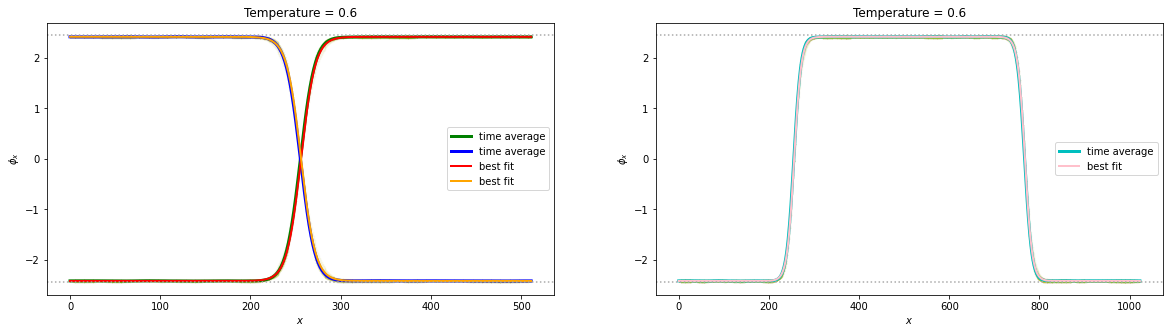

mean : 2.35162958954503 0.05731801444862166
mean : 2.35285368899631 0.056063192592710254
mean : 2.3522377973632045 0.05668446180814009 -2.352015076098187
cf : 2.449489742783178


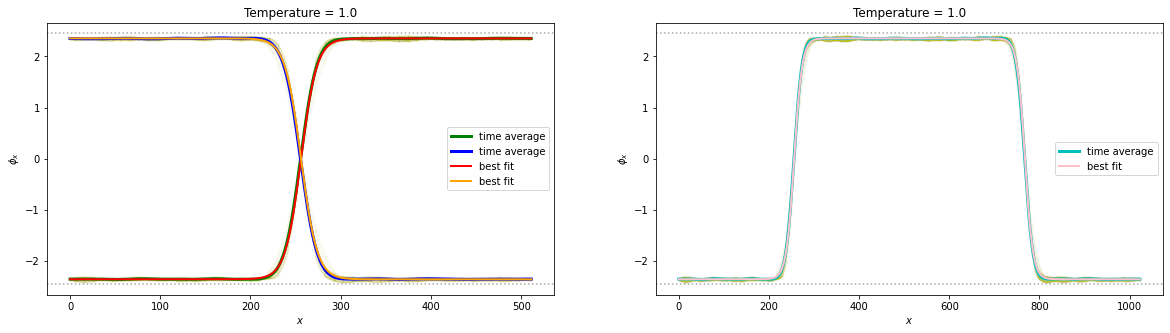

In [7]:
def tanh_fit1(x, a1, a2):
    return a1*np.tanh(a2 * (x-nLat/4.))
def tanh_fit2(x, a1, a2):
    return a1*np.tanh(-a2 * (x-nLat/4.))
def tanh_fit3(x, a1, a2, a3):
    return a1*(np.tanh(a2 * (x-nLat/4.)) - np.tanh(a2 * (x-3.*nLat/4.))) + a3

list_time = np.asarray([int(time) for time in range(int(5*m2eff/dtout))]); print('max time:', list_time[-1])
xlist1 = np.arange(nLat//2)
xlist2 = np.arange(nLat//2,nLat)
xlist3 = np.arange(nLat)

for tt, temp in enumerate(list_temp):
    fig, ax = plt.subplots(1, 2, figsize = (20, 5))
    # plot each slice
    for time in list_time:
        ax[0].plot(xlist1,  np.mean(all_data[tt,:,0,time,xlist1], axis=1), marker = 'o', ms=1, color='y', alpha=0.02, ls='None')
        ax[0].plot(xlist1,  np.mean(all_data[tt,:,0,time,xlist2], axis=1), marker = 'o', ms=1, color='y', alpha=0.02, ls='None')
        ax[1].plot(xlist3,  np.mean(all_data[tt,:,0,time,xlist3], axis=1), marker = 'o', ms=1, color='y', alpha=0.02, ls='None')
    # mean of all slices
    average_curve_in_sims1 = np.mean([np.mean(all_data[tt,:,0,time,xlist1], axis=1) for time in list_time], axis=0)
    average_curve_in_sims2 = np.mean([np.mean(all_data[tt,:,0,time,xlist2], axis=1) for time in list_time], axis=0)
    average_curve_in_sims3 = np.mean([np.mean(all_data[tt,:,0,time,xlist3], axis=1) for time in list_time], axis=0)
    ax[0].plot(xlist1, average_curve_in_sims1, label='time average', linewidth=3, color='g')
    ax[0].plot(xlist1, average_curve_in_sims2, label='time average', linewidth=3, color='b')
    ax[1].plot(xlist3, average_curve_in_sims3, label='time average', linewidth=3, color='c')

    # best fit of mean
    popt1, pcov1 = scp.optimize.curve_fit(tanh_fit1, xlist1, average_curve_in_sims1)
    popt2, pcov2 = scp.optimize.curve_fit(tanh_fit2, xlist1, average_curve_in_sims2)
    popt3, pcov3 = scp.optimize.curve_fit(tanh_fit3, xlist3, average_curve_in_sims3)
    ax[0].plot(xlist1, tanh_fit1(xlist1, *popt1), label='best fit', linewidth=2, color='r')
    ax[0].plot(xlist1, tanh_fit2(xlist1, *popt2), label='best fit', linewidth=2, color='orange')
    ax[1].plot(xlist3, tanh_fit3(xlist3, *popt3), label='best fit', linewidth=2, color='pink')

    print('mean :', *popt1)
    print('mean :', *popt2)
    print('mean :', *popt3)
    print('cf :', np.sqrt(m2eff*6/lamb))

    for ii in ax:
        ii.axhline(-m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
        ii.axhline(m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
        ii.set_xlabel(f'$x$')
        ii.set_ylabel(f'$\phi_x$')
        ii.legend()
        ii.set_title('Temperature = '+str(temp))
    plt.show()

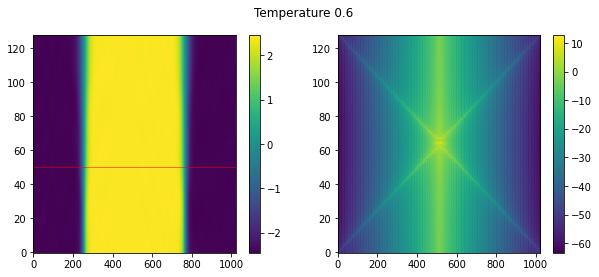

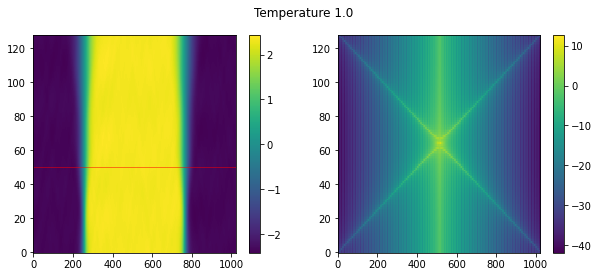

In [8]:
for tt, temp in enumerate(list_temp):
    PowSpec = np.mean(np.abs(np.fft.fftshift(np.fft.fft2(all_data[tt,:,0], norm='ortho')))**2., axis=0)

    fig, ax = plt.subplots(1, 2, figsize = (10, 4))
    im0 = ax[0].imshow(np.mean(all_data[tt], axis=0)[0], aspect='auto', interpolation='none', origin='lower')
    ax[0].axhline(list_time[-1], color='r', linewidth=0.5)
    clb = plt.colorbar(im0, ax = ax[0])
    np.save(plot_path+'average_simulation_of_stable_soln_at_T'+str(temp)+'.npy', np.mean(all_data, axis=0)[0])

    im0 = ax[1].imshow(np.log(PowSpec), aspect='auto', interpolation='none', origin='lower')
    clb = plt.colorbar(im0, ax = ax[1])
    np.save(plot_path+'average_pow_spec_of_stable_soln_at_T'+str(temp)+'.npy', PowSpec)
    plt.suptitle('Temperature '+str(temp))
    plt.show()

max time: 9.86328125


No handles with labels found to put in legend.
No handles with labels found to put in legend.


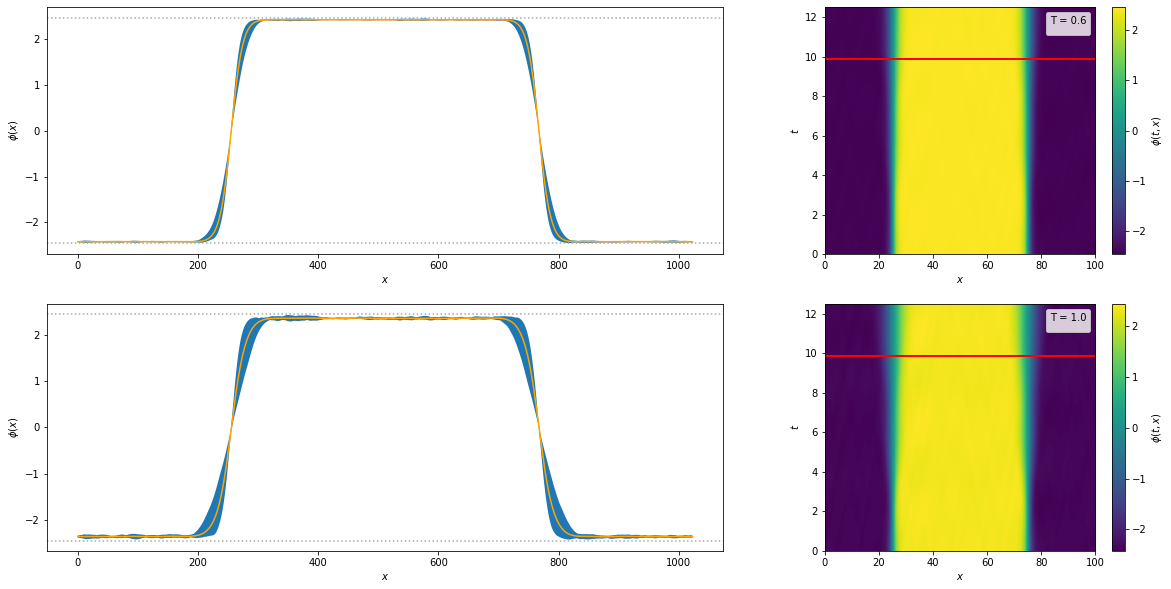

In [36]:
list_time = np.asarray([int(time) for time in range(int(10*m2eff/dtout))]); print('max time:', list_time[-1]*dtout)

fig, ax = plt.subplots(2, 2, figsize = (20, 10), gridspec_kw={'width_ratios': [2,1], 'height_ratios': [1,1]})
for tt, temp in enumerate(list_temp):
    # plot each slice
    grid = [np.mean([all_data[tt,sim,0,time] for sim in range(nSims)], axis=0) for time in list_time]
    ax[tt][0].fill_between(np.arange(nLat), np.amin(grid, axis=0), np.amax(grid, axis=0))

#    for time in list_time:
#        ax[tt][0].plot(np.arange(nLat), np.mean([all_data[tt,sim,0,time] for sim in range(nSims)], axis=0), color='purple', alpha=0.1)
    
    # mean of all slices
    average_curve_in_sims3 = np.mean([np.mean([all_data[tt,sim,0,time] for sim in range(nSims)], axis=0) for time in list_time], axis=0)
    ax[tt][0].plot(np.arange(nLat), average_curve_in_sims3, color='orange')

    ext = [0, nLat*dx, 0, nTime*dtout]
    im0 = ax[tt][1].imshow(np.mean([all_data[tt,sim,0] for sim in range(nSims)], axis=0), aspect='auto', interpolation='none', origin='lower', extent=ext)
    ax[tt][1].axhline(list_time[-1]*dtout, color='r', linewidth=2)
    clb = plt.colorbar(im0, ax = ax[tt][1])
    clb.set_label(r'$\phi(t,x)$')
    ax[tt][1].set_xlabel('$x$')
    ax[tt][1].set_ylabel('$t$')
    ax[tt][1].legend(title='T = '+str(temp))

    ax[tt][0].axhline(-m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
    ax[tt][0].axhline(m2eff*np.sqrt(6/lamb), linestyle=":", color='darkgray')
    ax[tt][0].set_xlabel(f'$x$')
    ax[tt][0].set_ylabel(f'$\phi(x)$')
plt.show()

In [37]:
# DSolve[{D[\[CurlyPhi][r],{r,2}]==m2 \[CurlyPhi][r],\[CurlyPhi][0]==-Sqrt[6m2],(\[CurlyPhi]^\[Prime])[0]==0},\[CurlyPhi][r],r]//FullSimplify
def exp_tail_fit(x, a, b, m):
    return a + b * np.exp(x * dx * m)
def exp_tail_fit(x, a, b, m):
    return a + b * m * np.cosh(x * dx * m)


def get_sth(tt, temp, list_stops):
    step = 2
    more_storage = []
    for STOPFITEARLY in list_stops:
        bool = (True if (STOPFITEARLY == list_stops[0] or STOPFITEARLY == list_stops[-1]) else False)

        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = cycle(prop_cycle.by_key()['color'])
        xlist = np.arange(nLat)
        minx, maxx = min(xlist), max(xlist)//2
        curve = np.mean([np.mean([all_data[tt,sim,0,time] for sim in range(nSims)], axis=0) for time in list_time], axis=0)
        midindex = 256

        if bool:
            fig, ax = plt.subplots(1, 1, figsize = (10, 5))
            plt.plot(xlist, curve, label='full')

        storage = []
        for trunc in np.arange(minx+200, midindex+1 - STOPFITEARLY, step)[::-1]:
            col = next(colors)

            a1 = min(curve)
            tcurve1 = curve[minx:trunc] - a1
            xlist = np.arange(len(tcurve1))
            try:
                popt, pcov = scp.optimize.curve_fit(exp_tail_fit, xlist, tcurve1)
                if bool:
                    plt.plot(xlist[minx:trunc], tcurve1 + a1, 'o', ms=2, color=col)
                    plt.plot(xlist[minx:trunc], exp_tail_fit(xlist, *popt) + a1, color=col, linewidth=2)
                storage.append(popt)
            except:
                continue

            a2 = max(curve)
            tcurve2 = -curve[nLat//2:][minx:trunc] + a2
            xlist = np.arange(len(tcurve2))
            try:
                popt, pcov = scp.optimize.curve_fit(exp_tail_fit, xlist, tcurve2)
                if bool:
                    plt.plot(xlist[nLat//2:][minx:trunc], -tcurve2 + a2, '*', ms=2, color=col)
                    plt.plot(xlist[nLat//2:][minx:trunc], -exp_tail_fit(xlist, *popt) + a2, color=col, linewidth=2)
                storage.append(popt)
            except:
                continue

        if bool:
            plt.axhline(0, color='darkgray', ls=':')
            plt.axhline(np.sqrt(m2eff*6./lamb), color='darkgray', ls=':')
            plt.axhline(-np.sqrt(m2eff*6./lamb), color='darkgray', ls=':')
            plt.xlabel(f'$x$')
            plt.ylabel(f'$\phi_x$')
            plt.legend()
            plt.title('Temperature '+str(temp))
            plt.show()
        more_storage.append(np.asarray(storage))
    return more_storage

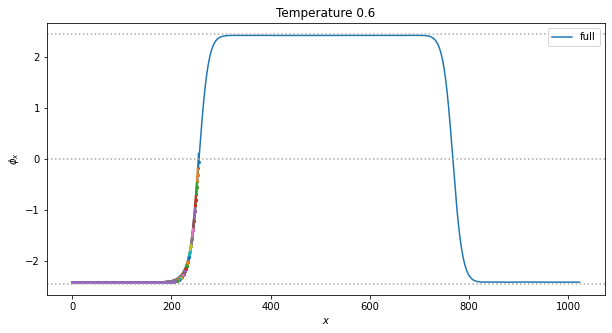

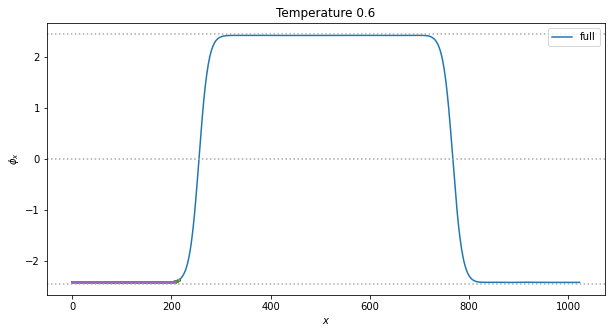

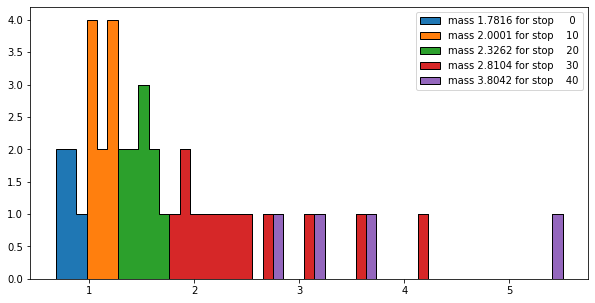

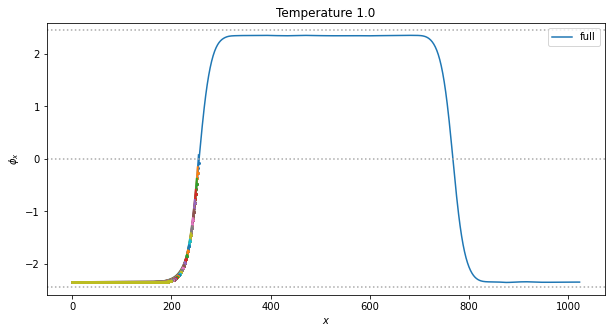

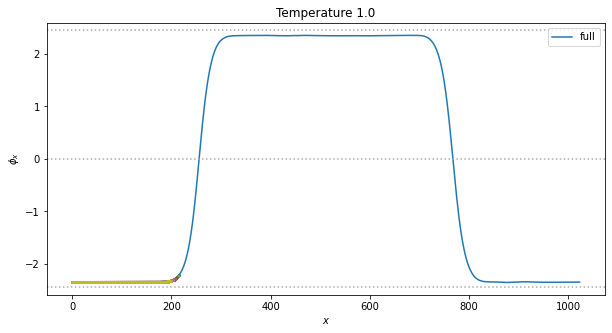

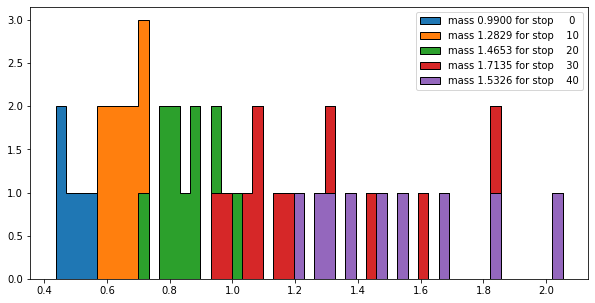

In [38]:
# the deviation comes from extending the possible fits all the way to where the field crosses the metastable point
# i.e. super large deviation from exponential solution
# check param STOPFITEARLY
for tt, temp in enumerate(list_temp):
    list_stops = np.arange(0, 41, 10)
    more_storage = get_sth(tt, temp, list_stops)

    fig, ax = plt.subplots(1, 1, figsize = (10, 5))
    binsave = np.histogram(more_storage[0][:,2]**2., bins=50)[1]
    for jj, storage in enumerate(more_storage):
        stop = list_stops[jj]
        plt.hist(storage[:,2]**2., bins=np.linspace(min(binsave), max(binsave), 50), label='mass %5.4f for stop %5.0f'%(np.mean(storage[:,2]**2.), stop), ec='k', histtype='stepfilled')
    plt.legend()
    plt.show()

### Recover Potential from Field Trajectory

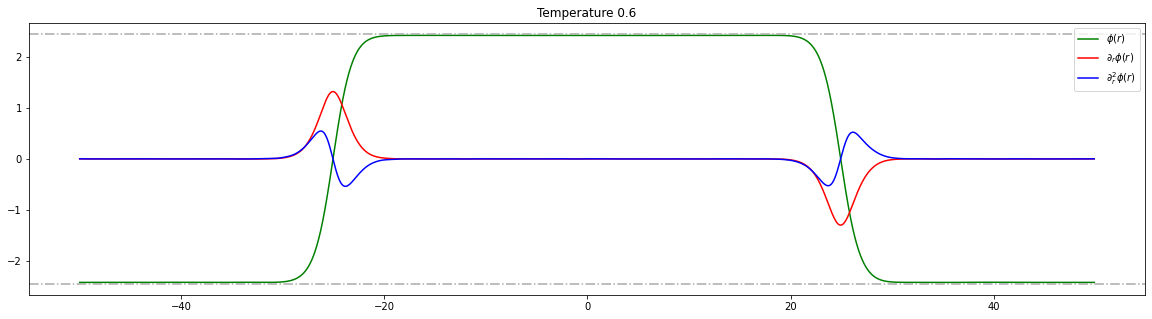

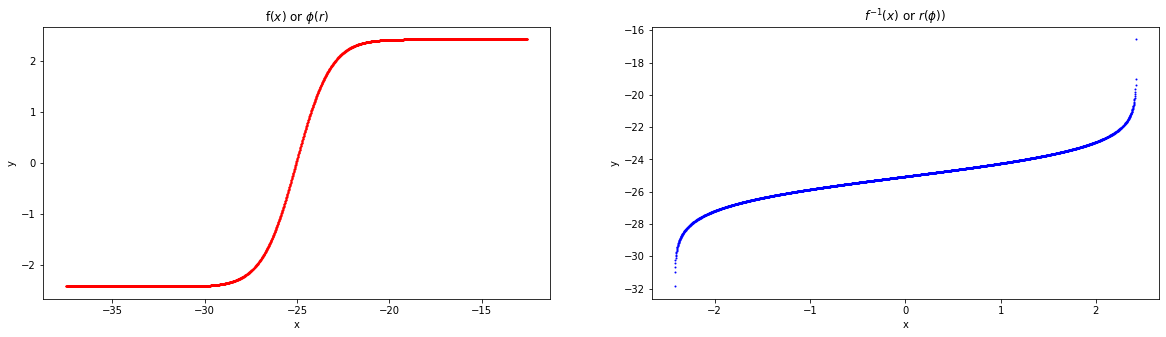

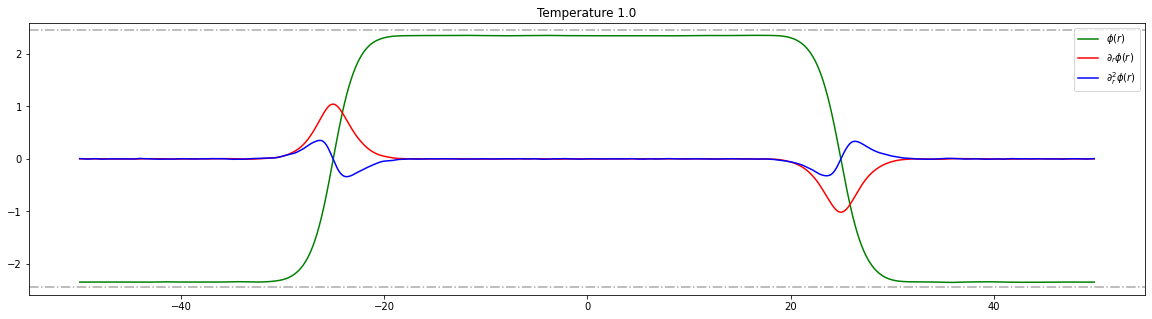

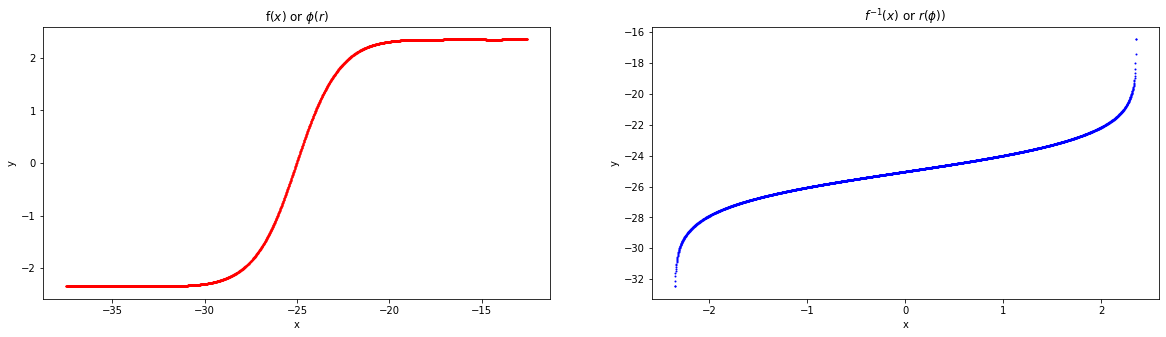

In [39]:
# interpolate mean field
# take tangent to this curve
# take tangent to tangent curve

for tt, temp in enumerate(list_temp):
    x = np.linspace(-nLat//2, nLat//2-1, nLat)*dx
    y = np.mean([np.mean([all_data[tt,sim,0,time] for sim in range(nSims)], axis=0) for time in list_time], axis=0)
    np.save(plot_path+'stable_solution_at_T'+str(temp)+'.npy', y)

    r = np.linspace(-nLat//2, nLat//2-1, 10*nLat)*dx
    f_phir = scp.interpolate.interp1d(x, y, kind='cubic')

    phi_spline = scp.interpolate.splrep(r, f_phir(r))
    dphidr = scp.interpolate.splev(r, phi_spline, der=1)
    ddphiddr = scp.interpolate.splev(r, phi_spline, der=2)

    f_dphidr = scp.interpolate.interp1d(x, y, kind='cubic')
    f_ddphiddr = scp.interpolate.interp1d(x, y, kind='cubic')

    fig, ax = plt.subplots(1, 1, figsize = (20, 5))
    plt.plot(r, f_phir(r), 'g-', ms=1, label=f'$\phi(r)$')
    plt.plot(r, dphidr, 'r-', label=f'$\partial_r \phi(r)$')
    plt.plot(r, ddphiddr, 'b-', label=f'$\partial_r^2 \phi(r)$')

    plt.axhline(-np.sqrt(m2eff*6./lamb), color='darkgray', ls='-.')
    plt.axhline(np.sqrt(m2eff*6./lamb), color='darkgray', ls='-.')
    plt.title('Temperature '+str(temp))
    plt.legend()
    plt.show()
    
    # invert \phi(r) into r(\phi)
    function = lambda x: f_phir(x)
    diff = lambda x, a: (function(x) - a)**2.

    x = r[:len(r)//2]
    x = x[len(x)//4:3*len(x)//4]
    y = function(x)

    xinv = np.linspace(np.min(y), np.max(y), len(y))
    yinv = np.zeros(xinv.shape)

    for idx, x_value in enumerate(xinv):
        res = sco.minimize_scalar(diff, args=(x_value), bounds=(min(x), max(x)), method='Bounded')
        yinv[idx] = res.x

    fig, ax = plt.subplots(1, 2, figsize = (20, 5))
    ax[0].plot(x, y, 'ro', ms=1) # \phi(r)
    ax[0].set_title('f$(x)$ or $\phi(r)$')

    ax[1].plot(xinv, yinv, 'bo', ms=1) # r(\phi)
    ax[1].set_title(r'$f^{-1}(x)$ or $r(\phi))$')

    [jj.set_xlabel('x') for jj in ax]
    [jj.set_ylabel('y') for jj in ax]
    plt.show()
    
    # integrate product of derivatives above to get potential function of r
    dVdr_spline = scp.interpolate.splrep(r, dphidr*ddphiddr) # multiply field derivatives and get the corresponding spline
    Vofr_spline = scp.interpolate.splantider(dVdr_spline, n=1) # get integral spline of spline above

    Vofr = scp.interpolate.splev(r, Vofr_spline) # evaluate integral spline on trajectory
    Vofrofphi = scp.interpolate.splev(yinv, Vofr_spline) # evaluate integral spline on trajectory
    np.save(plot_path+'potential_at_T'+str(temp)+'.npy', (xinv, Vofrofphi))

m^2 = -0.4385
expected m^2 = -0.9096
m^2 = -0.6265
expected m^2 = -0.9692
m^2 = -1.0000


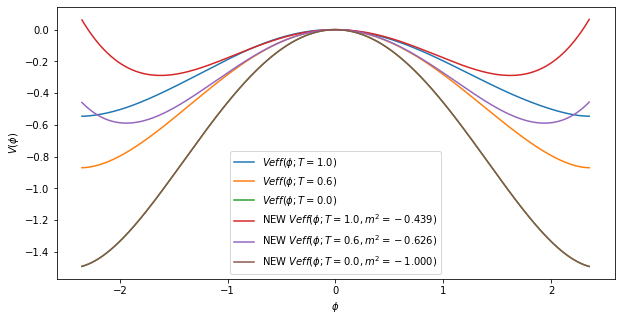

In [40]:
xinv, Vofrofphi06 = np.load(plot_path+'potential_at_T'+str(list_temp[0])+'.npy')
xinv, Vofrofphi10 = np.load(plot_path+'potential_at_T'+str(list_temp[1])+'.npy')

V = lambda phi: - 0.5*m2eff*phi**2. + lamb/24 * phi**4.
Veff = lambda phi, m2: 0.5*m2*phi**2. + lamb/24 * phi**4.

vector_data = [Vofrofphi10, Vofrofphi06, V(xinv)]
#vector_data = [np.roll(i, len(i)//2)-np.max(i) for i in vector_data]
vector_data = [i-np.max(i) for i in vector_data]
vector_data = np.asarray([np.asarray(i) for i in vector_data])

new_xinv = np.linspace(min(xinv), max(xinv), len(xinv)*5)
f = lambda i: scp.interpolate.interp1d(xinv, i, kind='cubic')

vector_data = [f(i)(new_xinv) for i in vector_data]

fig, ax = plt.subplots(1, 1, figsize = (10, 5))
[plt.plot(new_xinv, i, label=f'$Veff(\phi; T =  %5.1f)$'%([1., 0.6, 0.][j])) for j,i in enumerate(vector_data)]

ddVddphi = [scp.interpolate.splev(new_xinv, scp.interpolate.splrep(new_xinv, i), der=2) for i in vector_data]

second_derivative_at_max = [ddVddphi[i][j==max(j)][0] for i,j in enumerate(vector_data)]
#[plt.plot(new_xinv[j==max(j)], max(j), 'ro', label=f'$m^2 = %5.4f$'%(second_derivative_at_max[i])) for i,j in enumerate(vector_data)]

[plt.plot(new_xinv, Veff(new_xinv, j), label=f'NEW $Veff(\phi; T = %5.1f, m^2 =  %5.3f)$'%([1., 0.6, 0.][i], j)) for i,j in enumerate(second_derivative_at_max)]

for i,j in enumerate(vector_data):
    if i < 2:
        print('m^2 = %5.4f'%(ddVddphi[i][j==max(j)][0]))
        print('expected m^2 = %5.4f'%(th_masses([1., 0.6][i])))
    else:
        print('m^2 = %5.4f'%(ddVddphi[i][j==max(j)][0]))

plt.xlabel(f'$\phi$')
plt.ylabel(f'$V(\phi)$')
plt.legend()
plt.show()


In [41]:
def multiple_formatter(denominator=2, number=np.pi, latex='\pi'):
    def gcd(a, b):
        while b:
            a, b = b, a%b
        return a
    def _multiple_formatter(x, pos):
        den = denominator
        num = np.int(np.rint(den*x/number))
        com = gcd(num,den)
        (num,den) = (int(num/com),int(den/com))
        if den==1:
            if num==0:
                return r'$0$'
            if num==1:
                return r'$%s$'%latex
            elif num==-1:
                return r'$-%s$'%latex
            else:
                return r'$%s%s$'%(num,latex)
        else:
            if num==1:
                return r'$\frac{%s}{%s}$'%(latex,den)
            elif num==-1:
                return r'$\frac{-%s}{%s}$'%(latex,den)
            else:
                return r'$\frac{%s%s}{%s}$'%(num,latex,den)
    return _multiple_formatter

class Multiple:
    def __init__(self, denominator=2, number=np.pi, latex='\pi'):
        self.denominator = denominator
        self.number = number
        self.latex = latex
    def locator(self):
        return plt.MultipleLocator(self.number / self.denominator)
    def formatter(self):
        return plt.FuncFormatter(multiple_formatter(self.denominator, self.number, self.latex))


[-0.41252477  0.47658249]
[-0.61706921  0.65784036]
[-0.99999944  0.99999891]


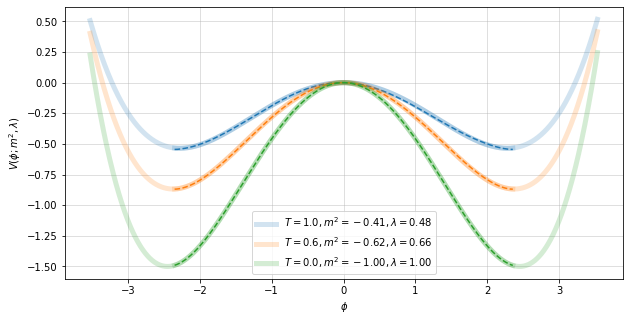

In [42]:
def fit_to_V(x, m2, lam):
    return 0.5*m2 * x**2. + lam/24. * x**4.

vector_data = [Vofrofphi10, Vofrofphi06, V(xinv)]
vector_data = [i-np.max(i) for i in vector_data]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = cycle(prop_cycle.by_key()['color'])
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
for j, curve in enumerate(vector_data):
    col = next(colors)
    
    popt, pcov = scp.optimize.curve_fit(fit_to_V, xinv, curve)
    print(popt)
    plt.plot(xinv, fit_to_V(xinv, *popt), color=col, label=r'$T = %5.1f, m^2 = %5.2f, \lambda = %5.2f$'%([1., 0.6, 0.][j], popt[0], popt[1]), linewidth=5, alpha=0.2)
    plt.plot(xinv, curve, color=col, ls='--')#, label=f'empirical curve with curvature $m^2 \sim Veff\' \' = %5.3f$'%(second_derivative_at_max[j]))
    extend_xinv = np.linspace(min(xinv)*1.5, max(xinv)*1.5, len(xinv))
    plt.plot(extend_xinv, fit_to_V(extend_xinv, *popt), color=col, linewidth=5, alpha=0.2)#, label='extended curve from fit params')
#plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title=r'$V = \frac{1}{2}m^2\phi^2 + \frac{1}{4!}\lambda\phi^4$', title_fontsize='xx-large')
plt.legend()
plt.grid(alpha=0.5)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$V(\phi;m^2,\lambda)$')
#ax.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
#ax.xaxis.set_minor_locator(plt.MultipleLocator(np.pi / 2))
#ax.xaxis.set_major_formatter(plt.FuncFormatter(multiple_formatter()))
plt.savefig(plot_path+'empirical_potential.pdf')
plt.show()

In [43]:
[th_masses(tem) for tem in [0.6, 1]]

[-0.9692135483398475, -0.9095810806477208]